### **COLAB INSTALLATIONS AND DRIVE MOUNTING**

In [1]:
!pip install catboost 

     |████████████████████████████████| 65.9MB 48kB/s 


In [2]:
from google.colab import drive
drive.mount("/content/drive/")
%cd "drive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive


### **IMPORT NECESSARY LIBRARIES**

This solution to the Expresso Churn prediction challenge is a stack of three models(CatBoost, XGBoost and LGBM).

In [106]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb

### **HELPER FUNCTION**

This is where the cross validation loop and other processes are built for easy training and stacking throughout our workflow...  In this class, a variable "val_p" has been created. This is where all the predictions based on the validation set from each cross validation loop is stored, resulting to us having predictions based on the whole training data itself. Also, another 
variable "test_p" is where the test set predictions are stored.

In [107]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

### **DATA IMPORT AND CLEANING**

In [108]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [109]:
print(train.MRG.value_counts(dropna = False), 'Train length:', len(train), '\n')
print(test.MRG.value_counts(dropna = False), 'Test length:', len(test))

NO    400000
Name: MRG, dtype: int64 Train length: 400000 

NO    100000
Name: MRG, dtype: int64 Test length: 100000


From the cell above, it is quite obvious that our "MRG" column consists of only the value "NO" throughout the data set. It's best to remove such as it wouldn't introduce any information to our model.

In [110]:
train.drop(['user_id', 'MRG',], 1, inplace = True)
test.drop(['user_id', 'MRG',], 1, inplace = True)

### **DATA ENGINEERING**

In [111]:
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

In [112]:
data['REVENUE-MONTANT'] = data['REVENUE'] - data['MONTANT']
data['REVENUE/MONTANT'] = data['REVENUE'] / data['MONTANT']

In [113]:
data['TENURE'] = data['TENURE'].map({'K > 24 month': 24, 'I 18-21 month': 18, 'H 15-18 month': 15, 'G 12-15 month':12,
                                             'J 21-24 month': 21, 'F 9-12': 9, 'E 6-9 month':6, 'D 3-6 month':3})

In [114]:
#RETURN THE AVERAGE OF THE MONTH/TENURE BOUNDARIES
data['TENURE_avg'] = data['TENURE'].map({'K > 24 month': (24+27)/2, 'I 18-21 month':(18+21)/2 , 'H 15-18 month': (15+18)/2, 'G 12-15 month':(12+15)/2,
                                             'J 21-24 month': (21+24)/2, 'F 9-12': (9+12)/2, 'E 6-9 month':(6+9)/2, 'D 3-6 month':(3+6)/2})

In [115]:
data['TENURE/FREQUENCE_RECH'] = data['TENURE_avg'] / data['FREQUENCE_RECH']
data['TENURE/REGULARITY'] = data['TENURE_avg'] / data['REGULARITY']

During the competition, the REGION column seemed to add a lot of importance to my model and even grouping any other column based on "REGION" also added more value to my cross validation mean accuracy, I decided to group all columns based on "REGION".

In [116]:
region = data.groupby('REGION').mean()
region.drop('CHURN', 1, inplace = True)
cols = []
for i in region.columns:
    if i != 'REGION':
        region[i+'_reg_mean_all'] = region[i]
        region.drop(i, 1, inplace = True)
        cols.append(i+'_reg_mean_all')

data = pd.merge(data, region, on='REGION', how = 'left')
for col in cols: data[col+'_freq'] = data[col].map(data[col].value_counts().to_dict())/len(data)

In [117]:
data['freq*montant'] = data['FREQUENCE'] * data['MONTANT']
data['freq*rech'] = data['FREQUENCE'] * data['FREQUENCE_RECH']
data['freq*revenue'] = data['FREQUENCE'] * data['REVENUE']
data['freq*segment'] = data['FREQUENCE'] * data['ARPU_SEGMENT']

data['freq/montant'] =  data['MONTANT']/ data['FREQUENCE']
data['freq/rech'] = data['FREQUENCE'] / data['FREQUENCE_RECH']
data['freq/revenue'] = data['FREQUENCE'] / data['REVENUE']
data['freq/segment'] = data['FREQUENCE'] / data['ARPU_SEGMENT']

In [118]:
data['data/reg'] = data['DATA_VOLUME'] / data['REGULARITY']
data['net/reg'] = data['ON_NET'] / data['REGULARITY']
data['montant-rech/freq'] = (data['MONTANT'] - data['FREQUENCE_RECH']) / data['FREQUENCE']
data['segment/reg'] = data['ARPU_SEGMENT'] / data['REGULARITY']

In [119]:
data['reg_log'] = np.log1p(data['REGULARITY'])
data['rech_log'] = np.log1p(data['FREQUENCE_RECH'])
data['data_log'] = np.log1p(data['DATA_VOLUME'])
data['montant_log'] = np.log1p(data['MONTANT'])
data['rev_log'] = np.log1p(data['REVENUE'])
data['freq_log'] = np.log1p(data['FREQUENCE'])

In [120]:
data['reglog-montlog'] = data['reg_log'] - data['montant_log']
data['revlog/montlog'] = data['REVENUE'] / data['montant_log']
data['tenure/rechlog'] = data['TENURE_avg'] / data['rech_log']
data['reglog-datalog'] = data['reg_log'] - data['data_log']

In [121]:
drop = ['REGION', 'TOP_PACK']
data.drop(drop, 1, inplace = True)

Extract training data, test data and target

In [122]:
train = data[:ntrain].copy()
#train.drop_duplicates(inplace = True, ignore_index=True)
target = train.CHURN.copy()
train.drop('CHURN', axis=1, inplace=True)

test = data[ntrain:].copy()
test.drop('CHURN', axis=1, inplace=True)
test = test.reset_index(drop=True)

### **MODEL 1 - CATBOOST**

The CATBOOST and XGBOOST models were trained on GPU(Google Colab) in order to save time. To train on CPU, you would have to remove the **task_type** and **devices** parameters.

================================Fold1====================================
0:	learn: 0.9241709	test: 0.9255093	best: 0.9255093 (0)	total: 25ms	remaining: 4m 10s
50:	learn: 0.9294069	test: 0.9301955	best: 0.9301955 (50)	total: 1.06s	remaining: 3m 27s
100:	learn: 0.9299785	test: 0.9307400	best: 0.9307400 (100)	total: 1.96s	remaining: 3m 12s
150:	learn: 0.9303225	test: 0.9310062	best: 0.9310062 (150)	total: 2.84s	remaining: 3m 5s
200:	learn: 0.9305323	test: 0.9311327	best: 0.9311428 (196)	total: 3.73s	remaining: 3m 1s
250:	learn: 0.9306886	test: 0.9312153	best: 0.9312153 (250)	total: 4.63s	remaining: 2m 59s
300:	learn: 0.9308014	test: 0.9312926	best: 0.9312927 (298)	total: 5.54s	remaining: 2m 58s
350:	learn: 0.9308991	test: 0.9313439	best: 0.9313439 (350)	total: 6.43s	remaining: 2m 56s
400:	learn: 0.9309937	test: 0.9313872	best: 0.9313933 (395)	total: 7.33s	remaining: 2m 55s
450:	learn: 0.9311043	test: 0.9314346	best: 0.9314346 (450)	total: 8.23s	remaining: 2m 54s
500:	learn: 0.9311894	tes

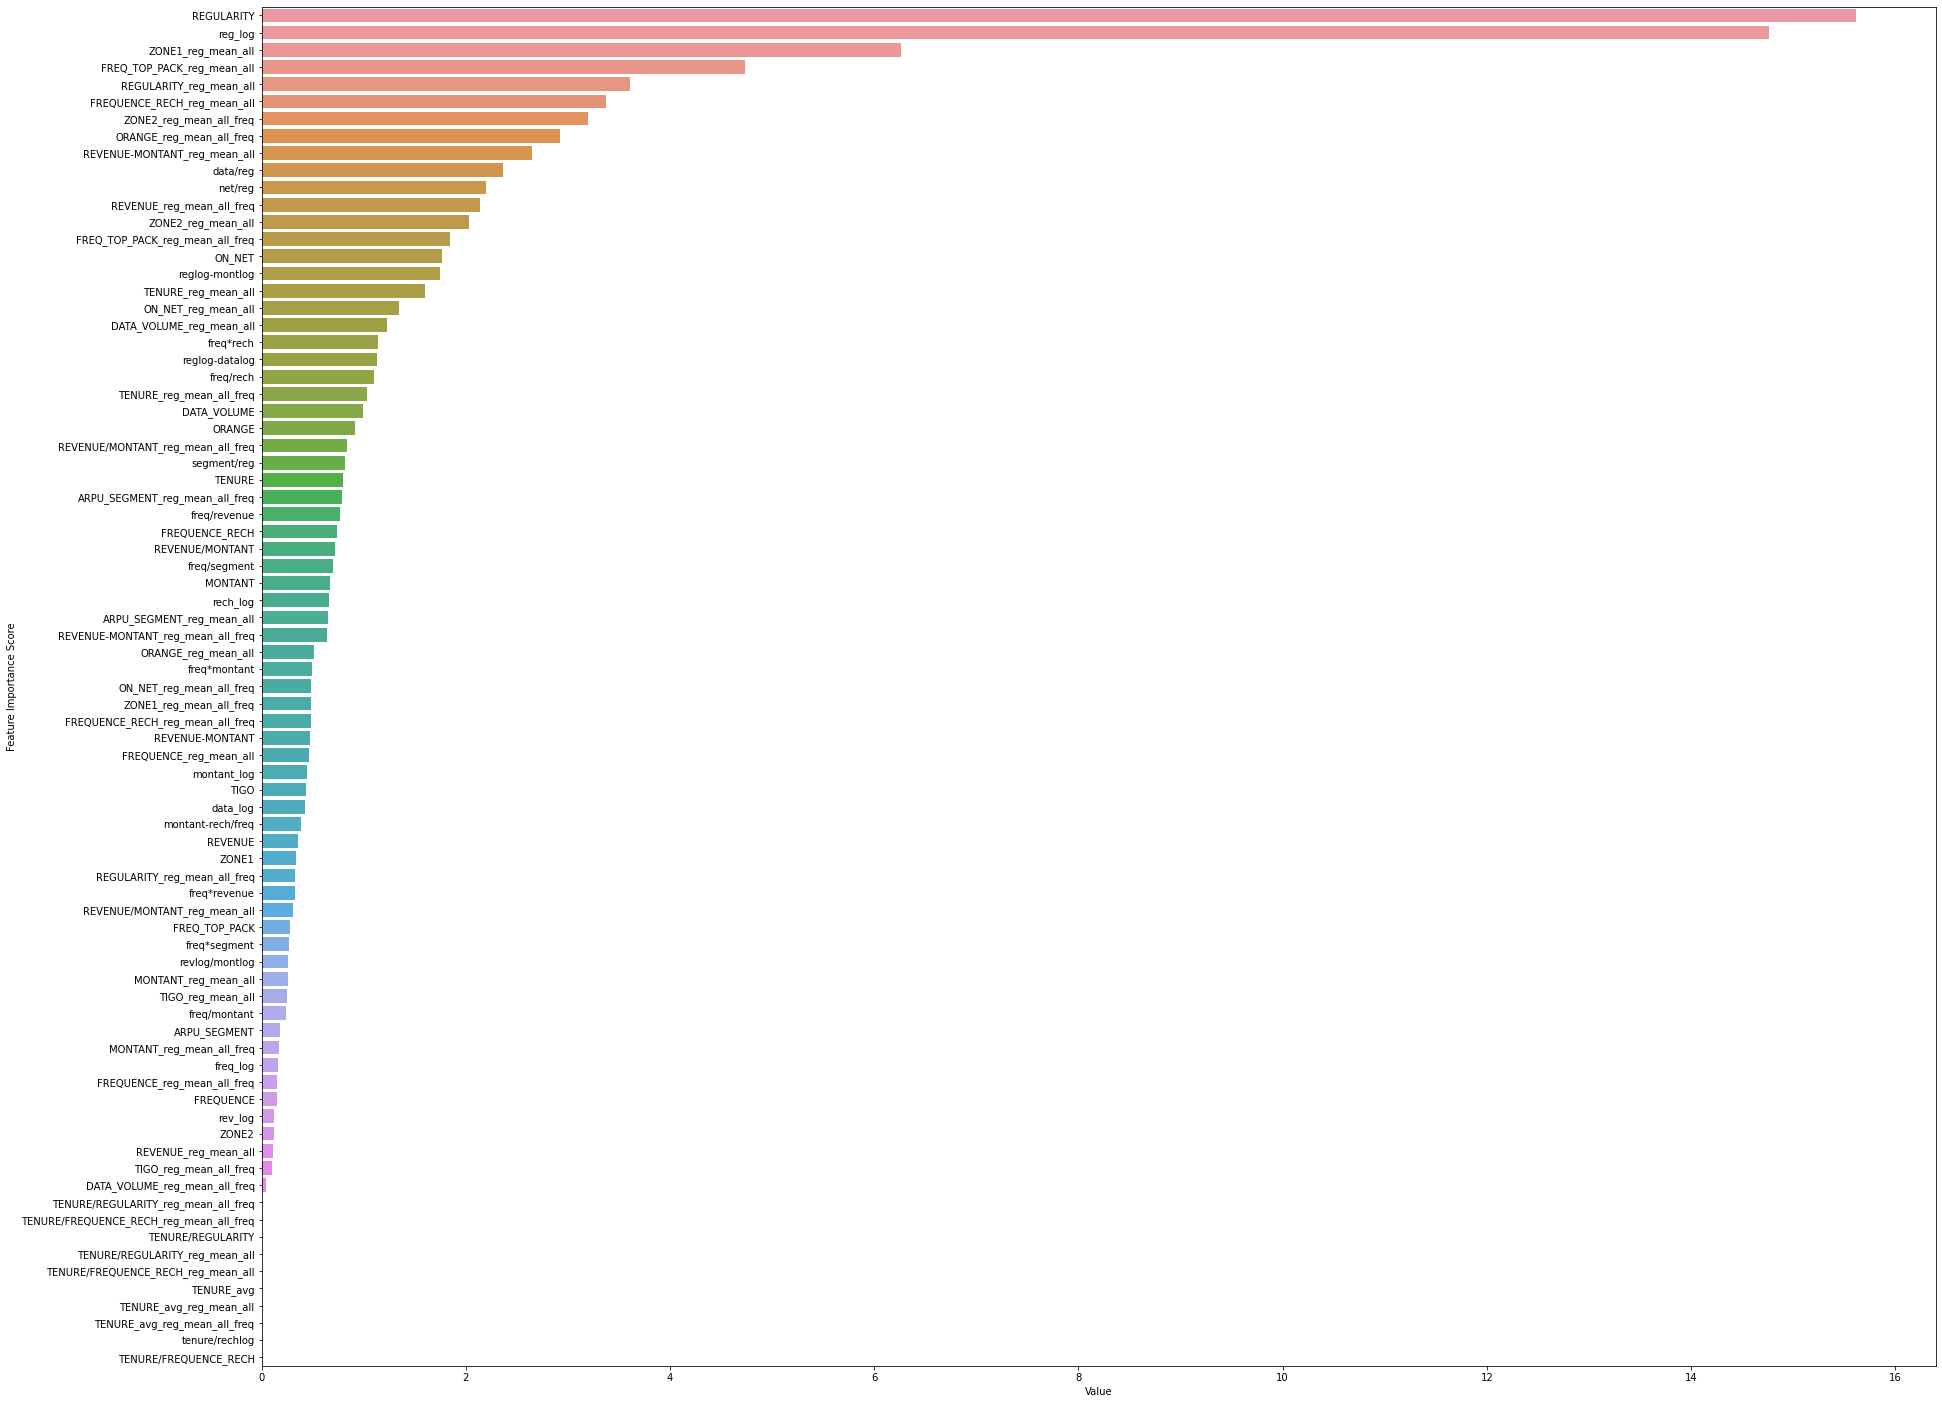

0.9308549465143294 0.933055622998943 0.0005958868777320145


In [123]:
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370, task_type="GPU", devices='0:1')

func_= func(train, target, test, catboost, 'catboost', 1000)
val_p1, test_p1, model1 = func_()

### **MODEL 2 - XGBOOST**

To train on CPU, you would have to remove the **tree_method** and **gpu_id** parameters.

================================Fold1====================================
[0]	validation_0-auc:0.891133
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.919762
[2]	validation_0-auc:0.922633
[3]	validation_0-auc:0.92371
[4]	validation_0-auc:0.92412
[5]	validation_0-auc:0.924856
[6]	validation_0-auc:0.925576
[7]	validation_0-auc:0.925747
[8]	validation_0-auc:0.925901
[9]	validation_0-auc:0.925966
[10]	validation_0-auc:0.926033
[11]	validation_0-auc:0.926105
[12]	validation_0-auc:0.926121
[13]	validation_0-auc:0.926176
[14]	validation_0-auc:0.92674
[15]	validation_0-auc:0.92678
[16]	validation_0-auc:0.927459
[17]	validation_0-auc:0.927508
[18]	validation_0-auc:0.927559
[19]	validation_0-auc:0.927618
[20]	validation_0-auc:0.927905
[21]	validation_0-auc:0.927928
[22]	validation_0-auc:0.928394
[23]	validation_0-auc:0.928413
[24]	validation_0-auc:0.928462
[25]	validation_0-auc:0.928499
[26]	validation_0-auc:0.928595
[27]	validation_0-auc:0.929112
[28]	val

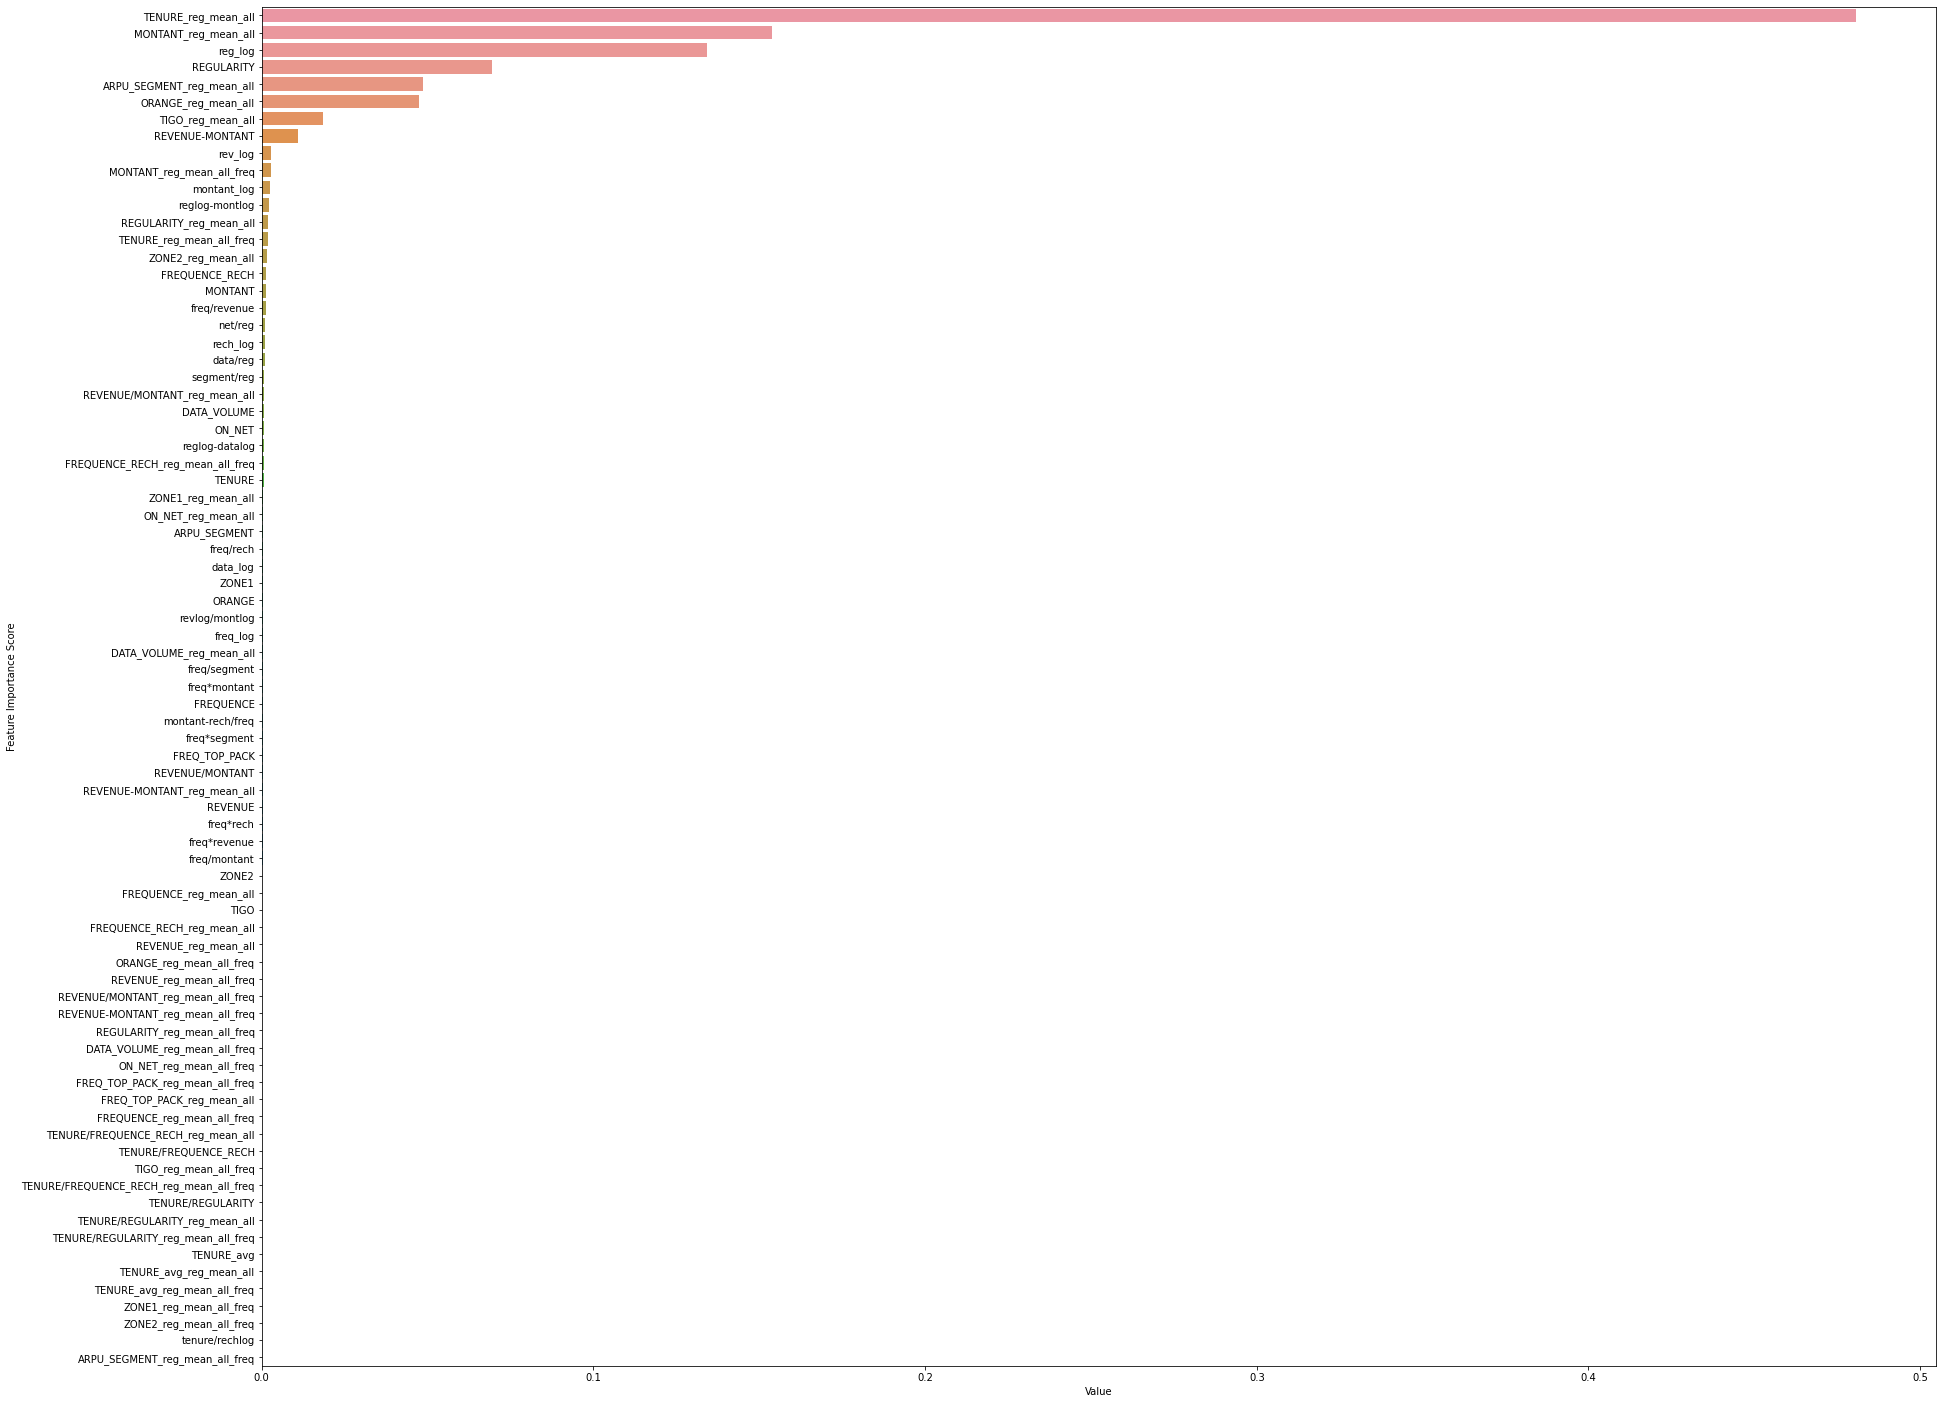

0.9306673826700586 0.9323614285130294 0.0006401957757293809


In [124]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8, tree_method='gpu_hist', gpu_id=0)

func_= func(train, target, test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

### **MODEL 3 - LGBM**

================================Fold1====================================
[1]	valid_0's auc: 0.928281
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.928491
[3]	valid_0's auc: 0.928618
[4]	valid_0's auc: 0.928822
[5]	valid_0's auc: 0.928897
[6]	valid_0's auc: 0.929098
[7]	valid_0's auc: 0.929126
[8]	valid_0's auc: 0.929143
[9]	valid_0's auc: 0.929303
[10]	valid_0's auc: 0.929983
[11]	valid_0's auc: 0.930115
[12]	valid_0's auc: 0.930148
[13]	valid_0's auc: 0.930166
[14]	valid_0's auc: 0.930198
[15]	valid_0's auc: 0.93021
[16]	valid_0's auc: 0.930237
[17]	valid_0's auc: 0.930413
[18]	valid_0's auc: 0.930566
[19]	valid_0's auc: 0.930623
[20]	valid_0's auc: 0.930657
[21]	valid_0's auc: 0.930675
[22]	valid_0's auc: 0.930723
[23]	valid_0's auc: 0.930876
[24]	valid_0's auc: 0.930908
[25]	valid_0's auc: 0.930938
[26]	valid_0's auc: 0.930932
[27]	valid_0's auc: 0.930953
[28]	valid_0's auc: 0.930968
[29]	valid_0's auc: 0.930983
[30]	valid_0's auc: 0.931095
[31]

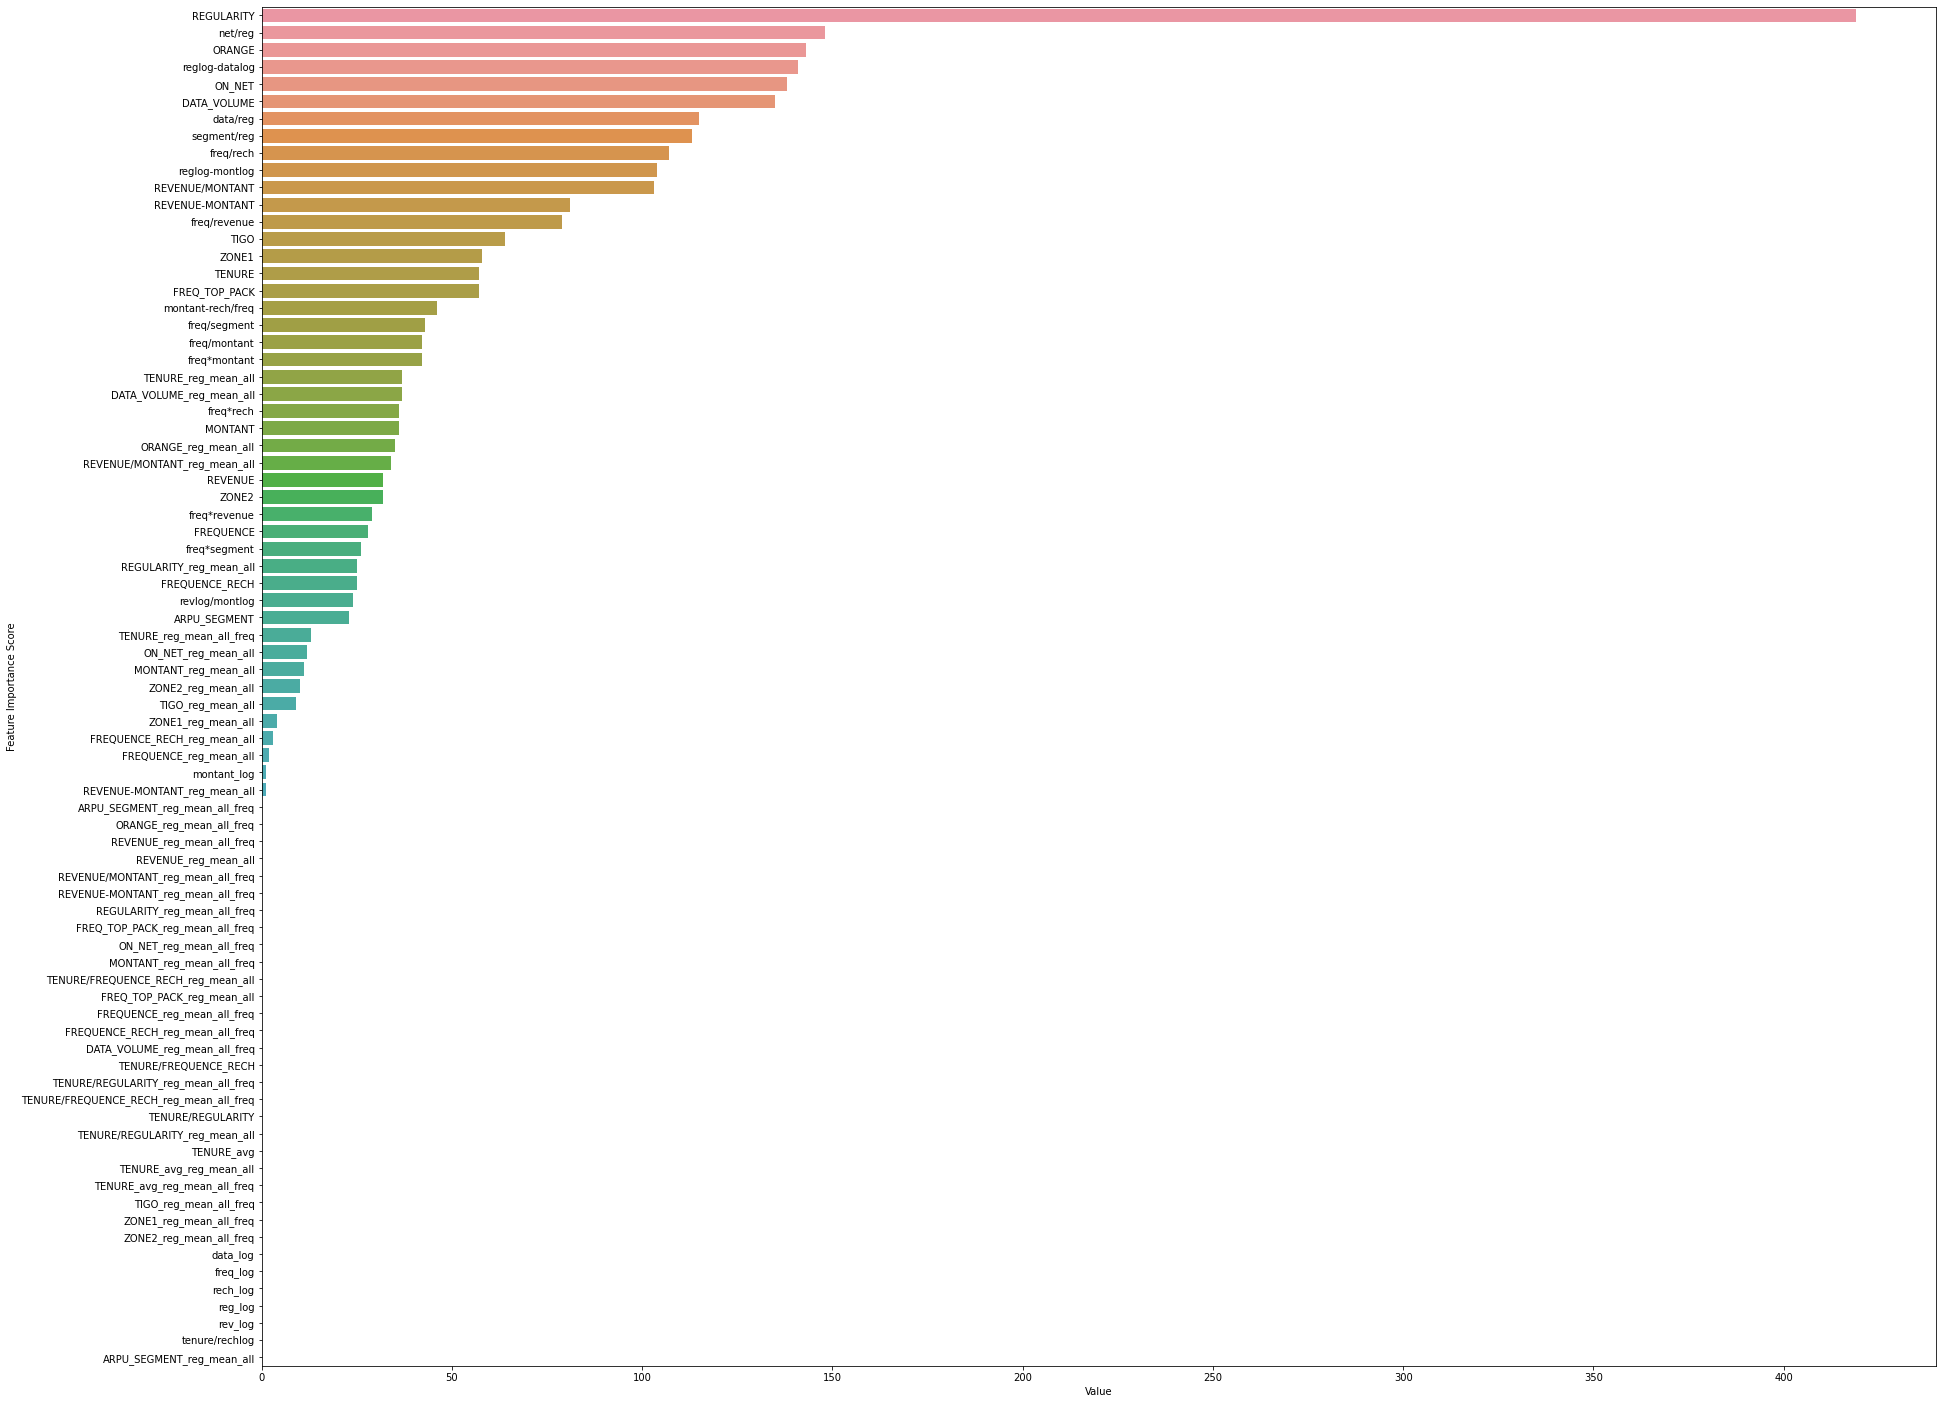

0.930743407857824 0.9328215407277558 0.0006822348551409715


In [125]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

func_= func(train, target, test, lgb_model, 'lgbm', 1000)
val_p3, test_p3, model3 = func_()

### **STACKING**

To stack, we use a simple algorithm as a meta-learner(Linear Regression) to finetune our predictions. We train this algorithm with the predictions of validation sets from all algorithms and use to produce the final predictions with the combination of the test set predictions from all algorithms.

In [126]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1, val_p2, val_p3))
stack_p = np.column_stack((test_p1, test_p2, test_p3))
predict = LinearRegression().fit(stack, target).predict(stack_p)

### **SUBMISSION**

In [127]:
submission['CHURN'] = predict

submission.to_csv('solution_stack.csv',index=False)

Final submission with this workflow should give a private leaderboard of 0.24666xxx, This was done by adding the n_estimators parameter for lgbm which was a mistake that wasn't done during the competition.

**FURTHER IMPROVEMENTS**
*   Feauture selection (Backward Elimination).
*   New column for rare values in the TOP_PACK column.
*   Better feature engineering(e.g. amount of missing columns in reach row/ flag if datapoint is missing)
*   Outlier handling
*   Train the different models on different random_seeds so as not to overfit a paticular seed
*   Add different features to different models, etc








